<a href="https://colab.research.google.com/github/dpostolovski/eeg_is/blob/visualisation_i/IS_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>
  <img alt="FINKI **LOGO**" height="30px" src="https://www.finki.ukim.mk/Content/dataImages/downloads/logo-large-500x500_2.png" hspace="10px" vspace="0px">
  Интелигентни системи - Лабораториска вежба 2 (Претпроцесирање)
</h1>

---



In [1]:
#@title Монтирање на Google Drive податочниот систем
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
#@title Инсталирање и вчитување на потребните библиотеки
!pip install mne

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
import mne

## Вчитување на податоците
Податоците ги вчитуваме во променливата data. Вчитаните податоци се претставени со тридимензионална матрица со димензии 8x350x1600.

In [3]:
# Вчитување на податочното множество
data = loadmat('drive/My Drive/Интелигентни Системи/Data/trainData.mat')['trainData'] 
# Вчитаните податоци се претставени со тридимензионална матрица каде првата
if data.shape[0] == 8:
  print("Податоците се успешно вчитани.")
else:
  print("Настана грешка во вчитувањето на податоците.")

Податоците се успешно вчитани.


In [7]:
ch_names = ["C3", "Cz", "C4", "CPz", "P3", "Pz", "P4", "POz"]

info = mne.create_info(ch_names=ch_names, sfreq=250, ch_types='eeg')

mdata_test = data

raw = mne.epochs.EpochsArray(np.swapaxes(mdata_test,0,1),info)

350 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


350 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


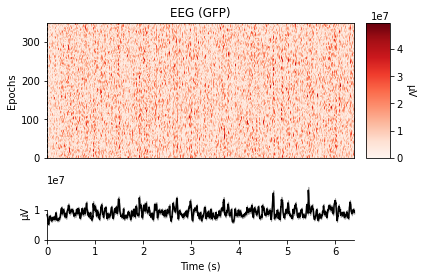

    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-8-4ccf3138fe33>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()


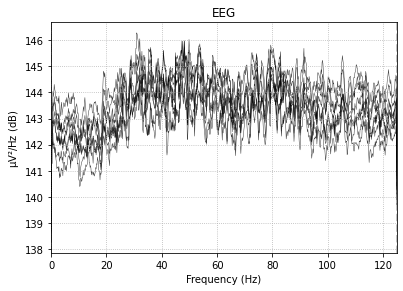

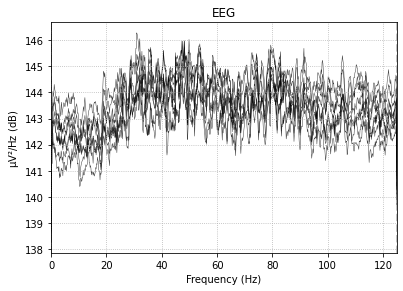

In [8]:
raw.plot_image()
raw.plot_psd()

Creating RawArray with float64 data, n_channels=8, n_times=1600
    Range : 0 ... 1599 =      0.000 ...     6.396 secs
Ready.
Effective window size : 6.400 (s)


<ipython-input-14-74bc71a2a67c>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()


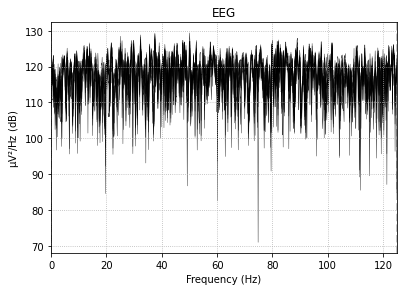

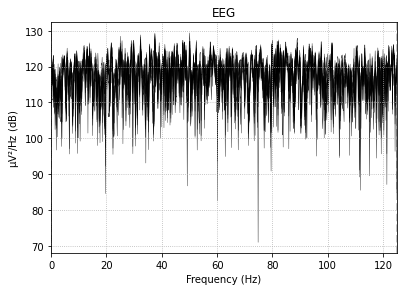

In [14]:
epoch_1 = np.swapaxes(mdata_test,0,1)[1]
raw = mne.io.RawArray(epoch_1,info)
raw.plot_psd()

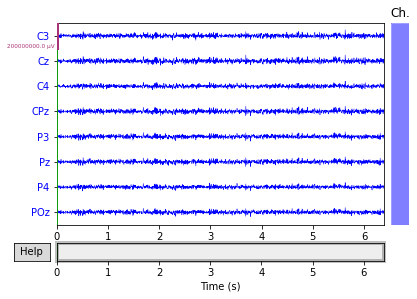

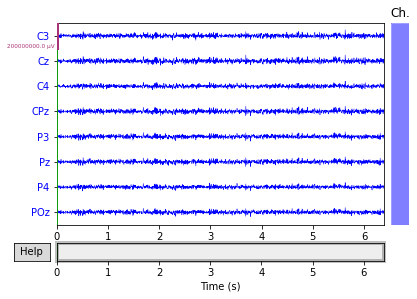

In [13]:
raw.plot(n_channels=8, scalings=100, title='Data from arrays',
         show=True, block=True, color = 'blue')

